# Project 3 Data cleaning and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS 
import seaborn as sns
pd.set_option('display.max_columns', None)
%matplotlib inline

### Table of Contents
- [Data Cleaning for null values and duplicates](#Data-Cleaning-for-null-values-and-duplicates)
- [Combine both subreddit dataframes](#Combine-both-subreddit-dataframes)
- [Cleaning function for all_text column](#Cleaning-function-for-all_text-column)
- [EDA](#EDA)

## Data Cleaning for null values and duplicates

I'll be dropping rows null values as it will not contribute to EDA and duplicates rows as well as it will impact the classification process

In [2]:
#read csv files
pf_df = pd.read_csv('./datasets/ddup_personalfinance.csv')
loan_df = pd.read_csv('./datasets/ddup_loan.csv')

In [3]:
#see the null values for pf_df
pf_df.isnull().sum()

Unnamed: 0    0
name          0
subreddit     0
title         0
selftext      1
dtype: int64

In [4]:
#drop null values
pf_df=pf_df.dropna().reset_index(drop=True)

In [5]:
pf_df.isnull().sum()

Unnamed: 0    0
name          0
subreddit     0
title         0
selftext      0
dtype: int64

In [6]:
pf_df[pf_df['title']=='']


,Unnamed: 0,name,subreddit,title,selftext


In [7]:
pf_df[pf_df['selftext']=='']

,Unnamed: 0,name,subreddit,title,selftext


In [8]:
#see the null values for loan_df
loan_df.isnull().sum()

Unnamed: 0    0
name          0
subreddit     0
title         0
selftext      1
dtype: int64

In [9]:
#drop null values
loan_df=loan_df.dropna().reset_index(drop=True)



In [10]:
loan_df.isnull().sum()

Unnamed: 0    0
name          0
subreddit     0
title         0
selftext      0
dtype: int64

In [11]:
loan_df[loan_df['title']=='']

,Unnamed: 0,name,subreddit,title,selftext


In [12]:
loan_df[loan_df['selftext']=='']

,Unnamed: 0,name,subreddit,title,selftext


In [13]:
pf_df.shape

(993, 5)

In [14]:
loan_df.shape

(946, 5)

In [15]:
#drop duplicate for pf_df
pf_df.drop_duplicates(subset='selftext',keep='first',inplace=True,ignore_index=True)
pf_df.drop_duplicates(subset='title',keep='first',inplace=True,ignore_index=True)


In [16]:
pf_df.shape

(993, 5)

In [17]:
#drop duplicate for loan_df
loan_df.drop_duplicates(subset='selftext',keep='first',inplace=True,ignore_index=True)
loan_df.drop_duplicates(subset='title',keep='first',inplace=True,ignore_index=True)


In [18]:
loan_df.shape

(946, 5)

## Combine both subreddit dataframes

In [19]:
#Combine both dataframes rows. 
comb_df = pd.concat([pf_df,loan_df]).reset_index(drop=True)


In [20]:
#drop unamed column
comb_df.drop(['Unnamed: 0'],axis=1,inplace=True)


In [21]:
comb_df.head()


,name,subreddit,title,selftext
0,t3_gjnn7e,personalfinance,Overwhelmed By My Finances &amp; Getting Force...,"So, the overview: I'm an out of work cook with..."
1,t3_gjnmwp,personalfinance,National Insurance - Year is Not Full,According to [tax.service.gov.uk](https://tax....
2,t3_gjnlbs,personalfinance,Refinancing Process,I’m in Wyoming. And I’m pursuing a refinance t...
3,t3_gjned9,personalfinance,Finally maxing out my SEP IRA (as an employee)...,"Like the title says, I am now financially able..."
4,t3_gjneqq,personalfinance,Advice for limiting damage from joint &amp; au...,My fiance's father is going through a pretty r...


In [22]:
#See the proportion of StudentLoans and personalfinance
comb_df['subreddit'].value_counts(normalize=True)


personalfinance    0.51212
StudentLoans       0.48788
Name: subreddit, dtype: float64

In [23]:
#see the overall shape of the combined dataframe
comb_df.shape

(1939, 4)

The difference in proportion between StudentLoans and personalfinance is about 0.03 so it should not make too much of an impact in modeling.

In [24]:
#combine title and selftext
comb_df['all_text'] = comb_df['title'] + comb_df['selftext']



In [25]:
comb_df.head()

,name,subreddit,title,selftext,all_text
0,t3_gjnn7e,personalfinance,Overwhelmed By My Finances &amp; Getting Force...,"So, the overview: I'm an out of work cook with...",Overwhelmed By My Finances &amp; Getting Force...
1,t3_gjnmwp,personalfinance,National Insurance - Year is Not Full,According to [tax.service.gov.uk](https://tax....,National Insurance - Year is Not FullAccording...
2,t3_gjnlbs,personalfinance,Refinancing Process,I’m in Wyoming. And I’m pursuing a refinance t...,Refinancing ProcessI’m in Wyoming. And I’m pur...
3,t3_gjned9,personalfinance,Finally maxing out my SEP IRA (as an employee)...,"Like the title says, I am now financially able...",Finally maxing out my SEP IRA (as an employee)...
4,t3_gjneqq,personalfinance,Advice for limiting damage from joint &amp; au...,My fiance's father is going through a pretty r...,Advice for limiting damage from joint &amp; au...


In [26]:
# create target variable, y which maps subreddit into a 1/0 column, where 1 indicates personalfinance
comb_df['y'] = [1 if i == 'personalfinance' else 0 for i in comb_df['subreddit']]


In [27]:
comb_df.head()

,name,subreddit,title,selftext,all_text,y
0,t3_gjnn7e,personalfinance,Overwhelmed By My Finances &amp; Getting Force...,"So, the overview: I'm an out of work cook with...",Overwhelmed By My Finances &amp; Getting Force...,1
1,t3_gjnmwp,personalfinance,National Insurance - Year is Not Full,According to [tax.service.gov.uk](https://tax....,National Insurance - Year is Not FullAccording...,1
2,t3_gjnlbs,personalfinance,Refinancing Process,I’m in Wyoming. And I’m pursuing a refinance t...,Refinancing ProcessI’m in Wyoming. And I’m pur...,1
3,t3_gjned9,personalfinance,Finally maxing out my SEP IRA (as an employee)...,"Like the title says, I am now financially able...",Finally maxing out my SEP IRA (as an employee)...,1
4,t3_gjneqq,personalfinance,Advice for limiting damage from joint &amp; au...,My fiance's father is going through a pretty r...,Advice for limiting damage from joint &amp; au...,1


## Cleaning function for all_text column

This function is to leave the all_text column with words that would be more related to the topic of the subreddits by removing HTML tags, words, symbols and digits that aren't useful as indidual elements when vectorzing and removing new lines. Stopwords are also taken out and the remaining words are lemmatized to reduce variations of basewords that might prolong the classifying process.

In [28]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    #Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    
    #remove https tags
    letters_only = re.sub(r'https?:\/\/.*[\r\n]*','',review_text)
    #remove punctuation
    letters_only = re.sub('\[.*?()\]','',letters_only)
    #removing words with numbers in them
    letters_only = re.sub('\w*d\w*','',letters_only)
    #removing numbers
    letters_only = re.sub('\d','',letters_only) 
    #remove words with 1 or 2 or 3 letters
    letters_only = re.sub(r"\b[a-zA-Z]{1,2,3}\b", "", letters_only)
    letters_only = re.sub("[^a-zA-Z]", " ", letters_only)
    #remove new lines
    letters_only = re.sub("\n"," ",letters_only)
    
    
    
    #Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
  
    
    #Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    #More words to remove after looking at the EDA section below
    more_stops= ['StudentLoans','investing','would','get','make','know','still','like','https',
                'com','www','take','go','going','think','want','see','try','come','also']
    
    meaningful_words = [w for w in meaningful_words if w not in more_stops]
    
    #Lemmatize words (Stemmer returns weird results like 'people' as 'peopl')
    lemm = WordNetLemmatizer()
    meaningful_words = [lemm.lemmatize(w) for w in meaningful_words]
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [29]:
# create column for cleaned all_text
comb_df['clean_text'] = comb_df['all_text'].apply(lambda x: review_to_words(x))

In [30]:
comb_df.head()

,name,subreddit,title,selftext,all_text,y,clean_text
0,t3_gjnn7e,personalfinance,Overwhelmed By My Finances &amp; Getting Force...,"So, the overview: I'm an out of work cook with...",Overwhelmed By My Finances &amp; Getting Force...,1,finance getting forceful othersso overview wor...
1,t3_gjnmwp,personalfinance,National Insurance - Year is Not Full,According to [tax.service.gov.uk](https://tax....,National Insurance - Year is Not FullAccording...,1,national insurance year one asking voluntary c...
2,t3_gjnlbs,personalfinance,Refinancing Process,I’m in Wyoming. And I’m pursuing a refinance t...,Refinancing ProcessI’m in Wyoming. And I’m pur...,1,refinancing processi wyoming pursuing refinanc...
3,t3_gjned9,personalfinance,Finally maxing out my SEP IRA (as an employee)...,"Like the title says, I am now financially able...",Finally maxing out my SEP IRA (as an employee)...,1,finally maxing sep ira employee title say fina...
4,t3_gjneqq,personalfinance,Advice for limiting damage from joint &amp; au...,My fiance's father is going through a pretty r...,Advice for limiting damage from joint &amp; au...,1,limiting joint user person go rehab fiance fat...


In [31]:
#See the first clean text after cleaning
comb_df['clean_text'][0]

'finance getting forceful othersso overview work cook k loan k perkins loan mental block kept really committing plan finance last emergency saving say k bank account since put halt many bill long term plan save time car problem year car great springing leak cartoon rowboat family commit k car loan car improve time car across multiple state sometimes mine far minus literally everything leak leaking committing car payment rate got k especially work likely return without huge career shift insane even best hr plus tip unreliable pay car payment anyway better car name case something happens offering k help payment nothing argument specific car year price strong opinion choice car well k obviously choosing car situation feel anything k figure pay k loan september th interest collection saying however long take away telling phone thought stress trying objectively responsible worth principle since actually took k loan x seems excessive screw man move life getting higher salary happily car paym

## EDA

Here we will do exploratory data analysis with bar charts of the top 20 words and a word cloud to get a sense of words occuring most frequently in both subreddits and are there irrelavent ones that can be taken out

In [32]:
# instantiate CountVectorizer and TfidfVectorizer 
cvec = CountVectorizer()
tfidf = TfidfVectorizer()

In [33]:
# CountVectorizer token counts for student loans and personal finance
cvec_loan = pd.DataFrame(cvec.fit_transform(comb_df[comb_df['subreddit']=='StudentLoans']['clean_text']).todense(),
                       columns=cvec.get_feature_names())

cvec_pf = pd.DataFrame(cvec.fit_transform(comb_df[comb_df['subreddit']=='personalfinance']['clean_text']).todense(),
                       columns=cvec.get_feature_names())


I have been looking the barcharts continously and putting words in the function above that aren't related to the subreddit topics like 'would' and 'com' so they get removed. The subreddit topics "StudentLoans' and 'investing' are also put in the function above to be removed before count vectorizing to minimize data leakage.

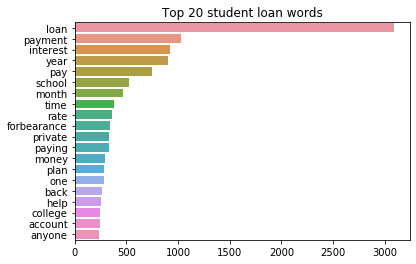

In [34]:
cvec_loan_20 = cvec_loan.sum().sort_values(ascending=False).head(20)

sns.barplot(y=cvec_loan_20.index.values, x = cvec_loan_20).set_title('Top 20 student loan words');

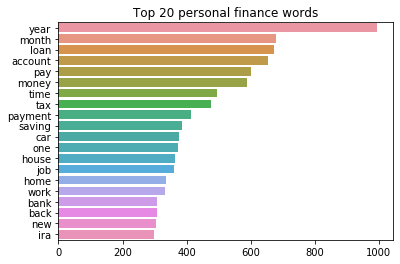

In [35]:
cvec_pf_20 = cvec_pf.sum().sort_values(ascending=False).head(20)

sns.barplot(y=cvec_pf_20.index.values, x = cvec_pf_20).set_title('Top 20 personal finance words');

I created a wordcloud function that can also help me see if there are anymore words to consider taking out. The more times a word appears in the wordcloud the bigger the word will appear in the wordcloud. I can see some common words like 'money' which I believe are relevant to the subreddit posts as people are always evaluating their current money situation when investing and taking up loans. Though it would be added challange for the model to classify correctly.

In [36]:
#define wordcloud function
def show_wordcloud(data, title):

    wordcloud = WordCloud(
       background_color='black',
       max_words=1000,
       colormap='brg',
       scale=3).generate(str(data))
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

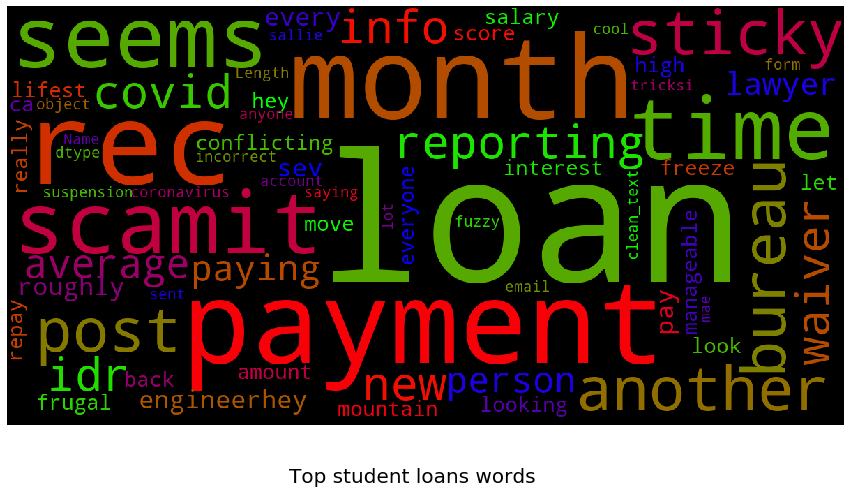

In [37]:
show_wordcloud(comb_df[comb_df['subreddit']=='StudentLoans']['clean_text'],'Top student loans words')

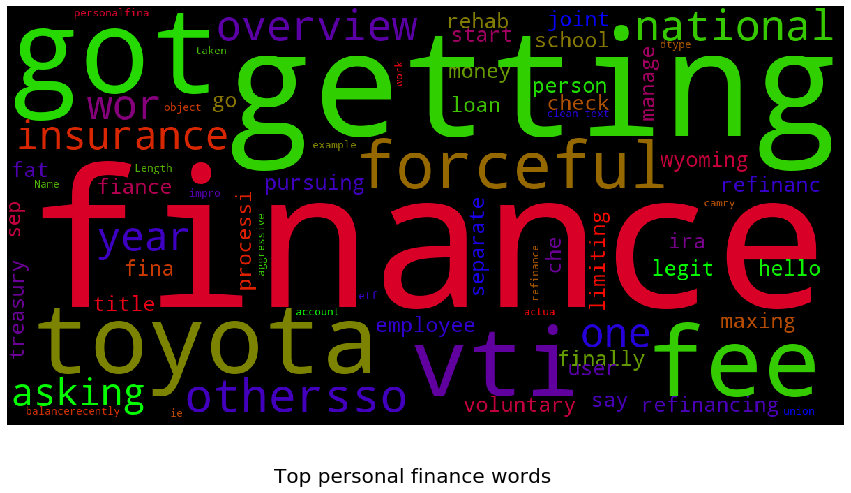

In [38]:
show_wordcloud(comb_df[comb_df['subreddit']=='personalfinance']['clean_text'],'Top personal finance words')

In [39]:
comb_df.drop(columns = ['name'],axis=1,inplace=True)

In [41]:
#save comb_df to csv
comb_df.to_csv('./datasets/comb_df.csv',index=False)